In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# optimization model
class myModel(optGrbModel):
    def __init__(self, weights):
        self.weights = np.array(weights)
        self.num_item = len(weights[0])
        super().__init__()

    def _getModel(self):
        # ceate a model
        m = gp.Model()
        # varibles
        x = m.addVars(self.num_item, name="x", vtype=GRB.BINARY)
        # model sense
        m.modelSense = GRB.MAXIMIZE
        # constraints
        m.addConstr(gp.quicksum([self.weights[0,i] * x[i] for i in range(self.num_item)]) <= 7)
        m.addConstr(gp.quicksum([self.weights[1,i] * x[i] for i in range(self.num_item)]) <= 8)
        m.addConstr(gp.quicksum([self.weights[2,i] * x[i] for i in range(self.num_item)]) <= 9)
        return m, x

In [4]:
from pyepo.predictive.pred import PredictivePrescription
from pyepo.model.opt import optModel
from pyepo import EPO

## UTILS

def test_model(prediction_model: PredictivePrescription, opt_model: optModel, x_test, c_test):
    loss = 0
    optsum = 0

    for x, true_cost in zip(x_test, c_test):
        pred_sol, _ = prediction_model.optimize(x)

        opt_model.setObj(true_cost)
        _, true_obj = opt_model.solve()

        pred_obj = opt_model.cal_obj(true_cost, pred_sol)

        if opt_model.modelSense == EPO.MINIMIZE:
            loss += pred_obj - true_obj
        if opt_model.modelSense == EPO.MAXIMIZE:
            loss += true_obj - pred_obj

        optsum += abs(true_obj)

    return loss/(optsum + 1e-7)


In [5]:
# generate data
num_data = 1000 # number of data
num_feat = 5 # size of feature
num_item = 10 # number of items
weights, x, c = pyepo.data.knapsack.genData(num_data, num_feat, num_item,dim=3, deg=4, noise_width=0.5, seed=135)

In [6]:
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=42)
optmodel = myModel(weights)

Restricted license - for non-production use only - expires 2026-11-23


In [7]:
from pyepo.predictive.nn import NearestPrediction
from pyepo.predictive.forest import RandomForestPrescription
from pyepo import EPO

predictor = NearestPrediction(x_train, c_train, 3, optmodel)
regret = test_model(predictor, optmodel, x_test, c_test)
print("regret nn", regret)

predictor = RandomForestPrescription(x_train, c_train, optmodel)
regret = test_model(predictor, optmodel, x_test, c_test)
print("regret RF", regret)

    

regret nn 0.1
regret RF 0.074842766


In [8]:
from torch import nn

class weigth_prediction(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, features): 
        """
        x: [B, D] query features
        features: [N, D] reference features
        returns: [B, N] normalized weights
        """
        B, N, D = features.shape

        # expand to compare every query with all reference features
        x_exp = x.unsqueeze(1).expand(-1, N, -1)        # [B, N, D]

        # concatenate query with corresponding reference features
        inp = torch.cat([x_exp, features], dim=-1)      # [B, N, 2D]

        weights = self.net(inp).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        return weights

In [9]:
from pyepo.predictive.neural import NeuralPrediction
weight_model = weigth_prediction(x_train.shape[1])
if torch.cuda.is_available():
    weight_model.cuda()
model = NeuralPrediction(x_train, c_train, weight_model, optmodel)

(800, 10)


In [10]:
model.train_model()

Num of cores: 1

Optimizing for optDataset...


100%|██████████| 640/640 [00:00<00:00, 13594.77it/s]


Optimizing for optDataset...



100%|██████████| 160/160 [00:00<00:00, 13626.17it/s]


In [11]:
regret = test_model(model, optmodel, x_test, c_test)
print(regret)

0.0754717


# Benchmark
Simple benchmark where number of datapoints gets higher

In [13]:
numbers_data = np.linspace(100,5000,30).astype(int)

nearest_neigbor_regrets = np.zeros(len(numbers_data))
neural_regrets = np.zeros(len(numbers_data))
rf_regrets = np.zeros(len(numbers_data))

num_feat = 5 # size of feature
num_item = 10 # number of items

for idx, num_data in enumerate(numbers_data):
    # generate data
    weights, x, c = pyepo.data.knapsack.genData(num_data, num_feat, num_item,dim=3, deg=4, noise_width=0.5, seed=135)

    x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=42) #This split is not ideal in this scenario
    optmodel = myModel(weights) 

    nearest_neigbor_predictor = NearestPrediction(x_train, c_train, 5, optmodel)

    weight_model = weigth_prediction(x_train.shape[1])
    if torch.cuda.is_available():
        weight_model.cuda()
    neural_predictor = NeuralPrediction(x_train, c_train, weight_model, optmodel)
    neural_predictor.train_model()

    rf_predictor = RandomForestPrescription(x_train, c_train, optmodel)

    #Run tests
    nearest_neigbor_regrets[idx] = test_model(nearest_neigbor_predictor, optmodel, x_test, c_test)
    neural_regrets[idx] = test_model(neural_predictor, optmodel, x_test, c_test)
    rf_regrets[idx] = test_model(rf_predictor, optmodel, x_test, c_test)





Num of cores: 1

Optimizing for optDataset...


100%|██████████| 64/64 [00:00<00:00, 12375.43it/s]


Optimizing for optDataset...



100%|██████████| 16/16 [00:00<00:00, 10633.63it/s]

Num of cores: 1

Optimizing for optDataset...


100%|██████████| 171/171 [00:00<00:00, 13368.11it/s]


Optimizing for optDataset...



100%|██████████| 43/43 [00:00<00:00, 12384.47it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 279/279 [00:00<00:00, 13515.17it/s]


Optimizing for optDataset...



100%|██████████| 70/70 [00:00<00:00, 12866.53it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 387/387 [00:00<00:00, 13610.90it/s]


Optimizing for optDataset...



100%|██████████| 97/97 [00:00<00:00, 13324.84it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 496/496 [00:00<00:00, 13588.52it/s]


Optimizing for optDataset...



100%|██████████| 124/124 [00:00<00:00, 13230.23it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 604/604 [00:00<00:00, 13677.94it/s]


Optimizing for optDataset...



100%|██████████| 151/151 [00:00<00:00, 13201.46it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 712/712 [00:00<00:00, 13391.50it/s]


Optimizing for optDataset...



100%|██████████| 178/178 [00:00<00:00, 13033.75it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 820/820 [00:00<00:00, 13538.16it/s]


Optimizing for optDataset...



100%|██████████| 205/205 [00:00<00:00, 13443.49it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 928/928 [00:00<00:00, 13763.58it/s]


Optimizing for optDataset...



100%|██████████| 232/232 [00:00<00:00, 13462.81it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1036/1036 [00:00<00:00, 13710.38it/s]


Optimizing for optDataset...



100%|██████████| 260/260 [00:00<00:00, 13363.39it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1144/1144 [00:00<00:00, 13660.13it/s]


Optimizing for optDataset...



100%|██████████| 287/287 [00:00<00:00, 13511.33it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1252/1252 [00:00<00:00, 13813.35it/s]


Optimizing for optDataset...



100%|██████████| 314/314 [00:00<00:00, 13579.82it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1360/1360 [00:00<00:00, 13714.95it/s]


Optimizing for optDataset...



100%|██████████| 341/341 [00:00<00:00, 13563.12it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1468/1468 [00:00<00:00, 13477.74it/s]


Optimizing for optDataset...



100%|██████████| 368/368 [00:00<00:00, 13250.21it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1577/1577 [00:00<00:00, 13758.31it/s]


Optimizing for optDataset...



100%|██████████| 395/395 [00:00<00:00, 13635.35it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1685/1685 [00:00<00:00, 13690.86it/s]


Optimizing for optDataset...



100%|██████████| 422/422 [00:00<00:00, 13702.74it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1793/1793 [00:00<00:00, 13737.60it/s]


Optimizing for optDataset...



100%|██████████| 449/449 [00:00<00:00, 13693.42it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 1901/1901 [00:00<00:00, 13829.72it/s]


Optimizing for optDataset...



100%|██████████| 476/476 [00:00<00:00, 13737.24it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2009/2009 [00:00<00:00, 13677.91it/s]


Optimizing for optDataset...



100%|██████████| 503/503 [00:00<00:00, 13494.70it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2118/2118 [00:00<00:00, 13705.12it/s]


Optimizing for optDataset...



100%|██████████| 530/530 [00:00<00:00, 13638.59it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2226/2226 [00:00<00:00, 13673.07it/s]


Optimizing for optDataset...



100%|██████████| 557/557 [00:00<00:00, 13481.14it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2334/2334 [00:00<00:00, 13572.26it/s]


Optimizing for optDataset...



100%|██████████| 584/584 [00:00<00:00, 13515.01it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2442/2442 [00:00<00:00, 13647.39it/s]


Optimizing for optDataset...



100%|██████████| 611/611 [00:00<00:00, 13502.42it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2550/2550 [00:00<00:00, 13834.19it/s]


Optimizing for optDataset...



100%|██████████| 638/638 [00:00<00:00, 13633.27it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2659/2659 [00:00<00:00, 13657.68it/s]


Optimizing for optDataset...



100%|██████████| 665/665 [00:00<00:00, 13694.36it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2767/2767 [00:00<00:00, 13751.28it/s]


Optimizing for optDataset...



100%|██████████| 692/692 [00:00<00:00, 13560.29it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2875/2875 [00:00<00:00, 13688.95it/s]


Optimizing for optDataset...



100%|██████████| 719/719 [00:00<00:00, 13553.36it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 2983/2983 [00:00<00:00, 13697.69it/s]


Optimizing for optDataset...



100%|██████████| 746/746 [00:00<00:00, 13700.39it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 3091/3091 [00:00<00:00, 13757.29it/s]


Optimizing for optDataset...



100%|██████████| 773/773 [00:00<00:00, 13733.82it/s]


Num of cores: 1

Optimizing for optDataset...


100%|██████████| 3200/3200 [00:00<00:00, 13706.69it/s]


Optimizing for optDataset...



100%|██████████| 800/800 [00:00<00:00, 13738.70it/s]


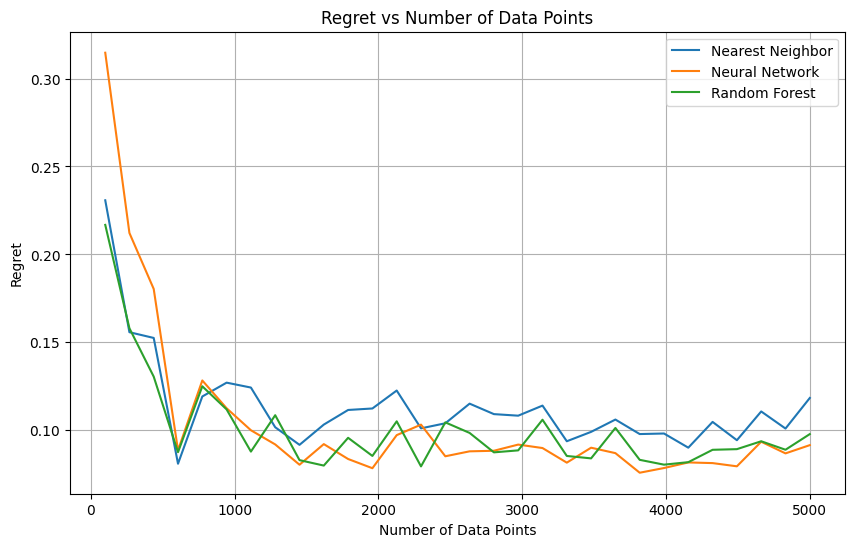

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(numbers_data, nearest_neigbor_regrets, label='Nearest Neighbor')
plt.plot(numbers_data, neural_regrets, label='Neural Network')
plt.plot(numbers_data, rf_regrets, label='Random Forest')
plt.xlabel('Number of Data Points')
plt.ylabel('Regret')
plt.title('Regret vs Number of Data Points')
plt.legend()
plt.grid(True)
plt.show()